In [1]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

2023-03-27 02:07:10.666674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 02:07:10.757602: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 02:07:11.238141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/vit-tf/lib/
2023-03-27 02:07:11.238190: W tensorflow/com

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## load model

> *1000 Epoch*

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir = '/media/SSD/rheology2023/VitModel/Regression/tensorflow/Exp-4/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
print(f"height: {height}, width: {width}")

2023-03-27 02:07:58.454800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 02:07:58.949968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9430 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


height: 224, width: 224


In [5]:
model.summary()

Model: "Vit_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None)

## Evaluation model

In [7]:
###** Test set

dataframe = pd.read_csv('/home/kannika/codes_AI/Rheology2023/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 8)


Unnamed: 0    GLY                                      folderName  \
0           0  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
1           1  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
2           2  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
3           3  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
4           4  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   

                                            fileName  \
0  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
1  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
2  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
3  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
4  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   

                                             pathimg  idt  MSDT subset  
0  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...  158  5.63   test  
1  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...   25  0.84   test  
2  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...    7  0.25   test  
3  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...  125  4.45   test  
4  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...   19  0.63   test

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [9]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict[0])
    print(predict)

2023-03-27 02:08:32.569450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-27 02:08:32.973010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-27 02:08:32.973767: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-27 02:08:32.973784: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-27 02:08:32.974508: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-27 02:08:32.974554: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 5s 5s/step
[7.3416677]
1/1 [==============================] - 0s 67ms/step
[0.6354635]
1/1 [==============================] - 0s 72ms/step
[0.3292179]
1/1 [==============================] - 0s 91ms/step
[5.8441596]
1/1 [==============================] - 0s 75ms/step
[0.53747594]
1/1 [==============================] - 0s 73ms/step
[3.498653]
1/1 [==============================] - 0s 67ms/step
[17.67631]
1/1 [==============================] - 0s 67ms/step
[34.40571]
1/1 [==============================] - 0s 70ms/step
[60.466484]
1/1 [==============================] - 0s 82ms/step
[0.22734025]
1/1 [==============================] - 0s 68ms/step
[18.264727]
1/1 [==============================] - 0s 71ms/step
[3.7059004]
1/1 [==============================] - 0s 65ms/step
[10.870268]
1/1 [==============================] - 0s 82ms/step
[0.45363563]
1/1 [==============================] - 0s 72ms/step
[1.0573759]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 67ms/step
[0.54240227]
1/1 [==============================] - 0s 78ms/step
[10.45901]
1/1 [==============================] - 0s 66ms/step
[0.836924]
1/1 [==============================] - 0s 64ms/step
[7.2146177]
1/1 [==============================] - 0s 69ms/step
[0.32821918]
1/1 [==============================] - 0s 73ms/step
[13.3484535]
1/1 [==============================] - 0s 71ms/step
[5.4119024]
1/1 [==============================] - 0s 70ms/step
[15.335222]
1/1 [==============================] - 0s 68ms/step
[2.3653893]
1/1 [==============================] - 0s 81ms/step
[0.4539703]
1/1 [==============================] - 0s 68ms/step
[0.4461817]
1/1 [==============================] - 0s 76ms/step
[39.237003]
1/1 [==============================] - 0s 76ms/step
[0.2700184]
1/1 [==============================] - 0s 70ms/step
[0.4041949]
1/1 [==============================] - 0s 68ms/step
[0.17773311]
1/1 [==============================] -

[0.06579379]
1/1 [==============================] - 0s 64ms/step
[1.3280132]
1/1 [==============================] - 0s 66ms/step
[6.4512925]
1/1 [==============================] - 0s 70ms/step
[11.423551]
1/1 [==============================] - 0s 84ms/step
[0.049764]
1/1 [==============================] - 0s 71ms/step
[0.59502757]
1/1 [==============================] - 0s 68ms/step
[0.7197962]
1/1 [==============================] - 0s 65ms/step
[4.694831]
1/1 [==============================] - 0s 63ms/step
[0.20022346]
1/1 [==============================] - 0s 94ms/step
[1.9612103]
1/1 [==============================] - 0s 72ms/step
[0.584319]
1/1 [==============================] - 0s 72ms/step
[0.077255]
1/1 [==============================] - 0s 73ms/step
[44.810978]
1/1 [==============================] - 0s 69ms/step
[0.577966]
1/1 [==============================] - 0s 65ms/step
[24.667616]
1/1 [==============================] - 0s 65ms/step
[0.7485254]
1/1 [=========================

1/1 [==============================] - 0s 71ms/step
[9.85839]
1/1 [==============================] - 0s 76ms/step
[16.29877]
1/1 [==============================] - 0s 67ms/step
[7.794326]
1/1 [==============================] - 0s 66ms/step
[0.30239925]
1/1 [==============================] - 0s 75ms/step
[15.690724]
1/1 [==============================] - 0s 72ms/step
[0.1857703]
1/1 [==============================] - 0s 63ms/step
[0.06798677]
1/1 [==============================] - 0s 73ms/step
[25.168303]
1/1 [==============================] - 0s 69ms/step
[9.851765]
1/1 [==============================] - 0s 71ms/step
[0.244067]
1/1 [==============================] - 0s 63ms/step
[0.37959653]
1/1 [==============================] - 0s 69ms/step
[0.05937552]
1/1 [==============================] - 0s 65ms/step
[0.9382514]
1/1 [==============================] - 0s 63ms/step
[0.21080531]
1/1 [==============================] - 0s 69ms/step
[19.352114]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 61ms/step
[2.1646326]
1/1 [==============================] - 0s 63ms/step
[0.04296565]
1/1 [==============================] - 0s 69ms/step
[0.16587466]
1/1 [==============================] - 0s 90ms/step
[0.14888357]
1/1 [==============================] - 0s 72ms/step
[1.8896924]
1/1 [==============================] - 0s 65ms/step
[10.960837]
1/1 [==============================] - 0s 65ms/step
[3.9749637]
1/1 [==============================] - 0s 66ms/step
[0.4508766]
1/1 [==============================] - 0s 70ms/step
[0.33504397]
1/1 [==============================] - 0s 61ms/step
[0.92144805]
1/1 [==============================] - 0s 63ms/step
[15.588498]
1/1 [==============================] - 0s 89ms/step
[0.36421525]
1/1 [==============================] - 0s 80ms/step
[0.5136099]
1/1 [==============================] - 0s 68ms/step
[0.13524574]
1/1 [==============================] - 0s 74ms/step
[1.0603864]
1/1 [============================

1/1 [==============================] - 0s 66ms/step
[0.56142944]
1/1 [==============================] - 0s 61ms/step
[1.1460059]
1/1 [==============================] - 0s 68ms/step
[0.04583334]
1/1 [==============================] - 0s 61ms/step
[0.19682255]
1/1 [==============================] - 0s 85ms/step
[0.07511418]
1/1 [==============================] - 0s 71ms/step
[0.08295105]
1/1 [==============================] - 0s 71ms/step
[0.05172479]
1/1 [==============================] - 0s 63ms/step
[0.16533297]
1/1 [==============================] - 0s 74ms/step
[0.18533196]
1/1 [==============================] - 0s 69ms/step
[0.7112144]
1/1 [==============================] - 0s 74ms/step
[0.28734684]
1/1 [==============================] - 0s 66ms/step
[1.8880765]
1/1 [==============================] - 0s 72ms/step
[1.7684467]
1/1 [==============================] - 0s 63ms/step
[7.242047]
1/1 [==============================] - 0s 64ms/step
[3.626288]
1/1 [============================

1/1 [==============================] - 0s 84ms/step
[0.7212146]
1/1 [==============================] - 0s 70ms/step
[0.13021508]
1/1 [==============================] - 0s 66ms/step
[0.36841387]
1/1 [==============================] - 0s 68ms/step
[0.15203574]
1/1 [==============================] - 0s 64ms/step
[0.13146359]
1/1 [==============================] - 0s 71ms/step
[0.35274076]
1/1 [==============================] - 0s 92ms/step
[0.1732502]
1/1 [==============================] - 0s 63ms/step
[0.3673302]
1/1 [==============================] - 0s 72ms/step
[0.18205997]
1/1 [==============================] - 0s 92ms/step
[0.16707599]
1/1 [==============================] - 0s 71ms/step
[1.1710744]
1/1 [==============================] - 0s 70ms/step
[0.15483578]
1/1 [==============================] - 0s 63ms/step
[0.14971417]
1/1 [==============================] - 0s 66ms/step
[0.1198682]
1/1 [==============================] - 0s 84ms/step
[0.15706322]
1/1 [=========================

In [10]:
pred_list

[7.3416677,
 0.6354635,
 0.3292179,
 5.8441596,
 0.53747594,
 3.498653,
 17.67631,
 34.40571,
 60.466484,
 0.22734025,
 18.264727,
 3.7059004,
 10.870268,
 0.45363563,
 1.0573759,
 0.24438122,
 32.88499,
 0.14496627,
 0.30839425,
 45.589283,
 11.164449,
 14.545062,
 0.57604146,
 0.3881194,
 26.074995,
 2.2098026,
 1.523453,
 5.799081,
 0.26456928,
 14.388199,
 38.0118,
 2.5905445,
 2.003641,
 0.16225794,
 0.1704006,
 12.40081,
 10.733619,
 5.567292,
 40.198174,
 0.80100745,
 0.25881457,
 21.345837,
 3.1436527,
 0.047100015,
 0.39433068,
 8.809474,
 1.2775332,
 0.30166572,
 47.613674,
 27.023685,
 0.18238594,
 61.85907,
 2.870464,
 0.2108585,
 1.1614594,
 0.27845085,
 6.720615,
 0.1206847,
 0.49696815,
 0.9941771,
 7.040236,
 10.650176,
 40.808643,
 0.20181493,
 29.857763,
 0.14344639,
 0.2603023,
 0.59607536,
 4.452134,
 3.631844,
 0.3273825,
 29.982075,
 0.17839907,
 12.7030525,
 0.79058444,
 4.895106,
 0.37926483,
 1.8647047,
 56.864388,
 23.420834,
 0.12016017,
 5.4447465,
 14.74608

In [11]:
print(len(pred_list))

dataframe['pre_MSDT'] = pred_list
dataframe.head(3)

870


Unnamed: 0    GLY                                      folderName  \
0           0  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
1           1  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   
2           2  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204   

                                            fileName  \
0  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
1  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   
2  GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...   

                                             pathimg  idt  MSDT subset  \
0  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...  158  5.63   test   
1  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...   25  0.84   test   
2  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...    7  0.25   test   

   pre_MSDT  
0  7.341668  
1  0.635463  
2  0.329218

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Root Mean squared error: %.4f" % mean_squared_error(y_test, pred_list, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_test, pred_list))
print("Mean absolute error: %.4f" % mean_absolute_error(y_test, pred_list))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, pred_list))

Root Mean squared error: 1.5210
Mean squared error: 2.3135
Mean absolute error: 0.6990
Coefficient of determination: 0.9704


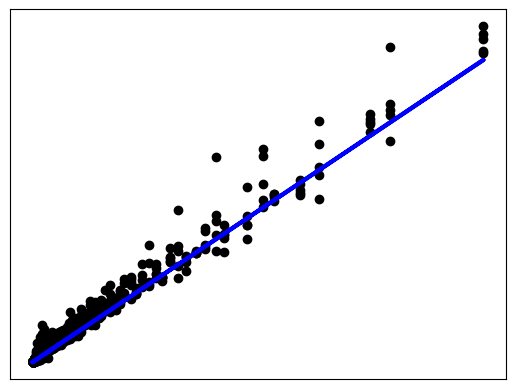

In [13]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## Plot : GLY10

> ## t & msd unit

In [14]:
import random

## Set solution
G = 10
_G = f"GLY{G}"

df_idt = pd.read_csv(f'/home/kannika/codes_AI/Rheology2023/MSDT_G{G}.csv')
print(df_idt.shape)
_GLY = dataframe[dataframe['GLY']==_G]
setFolder = list(set(_GLY['folderName']))
rand = random.choices(setFolder, k=1)
rand_ = rand[0]
df_rand = _GLY[_GLY['folderName']==rand_].reset_index(drop=True)
print(df_rand.shape)
df_rand = df_rand.sort_values(by=['idt'])
list_t = df_idt['t'].tolist()
df_rand['t'] = list_t
df_rand.head(3)

(29, 3)
(29, 9)


Unnamed: 0    GLY                                      folderName  \
25         112  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350   
12          99  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350   
4           91  GLY10  GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350   

                                             fileName  \
25  GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...   
12  GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...   
4   GLY10P100_D0_30HZ_20XINF_UWELL_20221229_193350...   

                                              pathimg  idt  MSDT subset  \
25  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...    1  0.05   test   
12  /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...    2  0.09   test   
4   /media/SSD/rheology2023/Glycerol_FFT_test/GLY1...    3  0.14   test   

    pre_MSDT         t  
25  0.195213  0.052498  
12  0.115293  0.091199  
4   0.259248  0.140551

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


y_testGLY10 = df_rand['MSDT'].tolist()
pred_listGLY10 = df_rand['pre_MSDT'].tolist()
# The mean squared error
print("========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========")
print("Root Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10, squared=False))
print("Mean squared error: %.4f" % mean_squared_error(y_testGLY10, pred_listGLY10))
print("Mean absolute error: %.4f" % mean_absolute_error(y_testGLY10, pred_listGLY10))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_testGLY10, pred_listGLY10))
print("-"*80)

========== Predict MSDT จาก Glycerol ความเข้มข้น 10% ==========
Root Mean squared error: 1.1201
Mean squared error: 1.2547
Mean absolute error: 0.6656
Coefficient of determination: 0.9939
--------------------------------------------------------------------------------


In [16]:
#df_idt['dt'].tolist()
lstMSDT = df_rand['MSDT'].tolist() 
lstpre_MSDT = df_rand['pre_MSDT'].tolist() 
print(len(lstMSDT))
print(len(lstpre_MSDT))

29
29


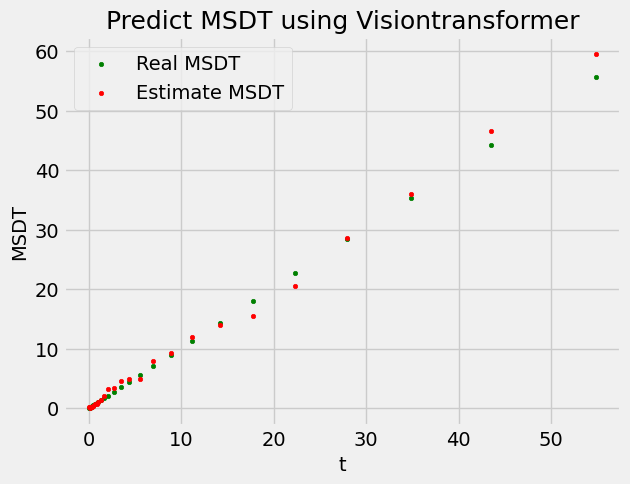

In [17]:
import matplotlib.pyplot as plt
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(list_t, lstMSDT,
            color = "green", s = 10, label = 'Real MSDT')
## plotting residual errors in test data
plt.scatter(list_t, lstpre_MSDT,
            color = "red", s = 10, label = 'Estimate MSDT')
## plotting line for zero residual error
#plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
## plotting legend
plt.legend(loc = 'upper left')
## plot title
plt.title("Predict MSDT using Visiontransformer", size=18)
plt.xlabel("t", size=14)
plt.ylabel("MSDT", size=14)
## method call for showing the plot
plt.show()

In [18]:
print(min(list_t))
print(max(list_t))

0.052498082
54.81658222


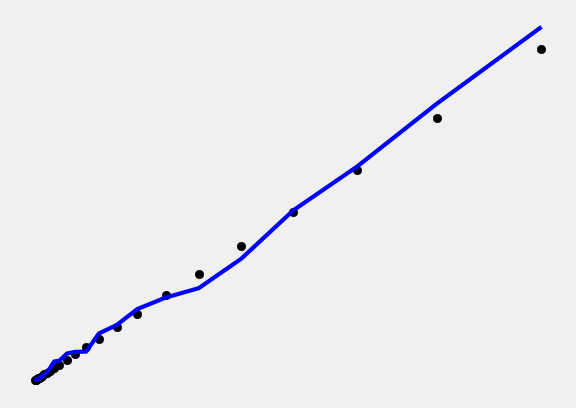

In [19]:
# Plot outputs
plt.scatter(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

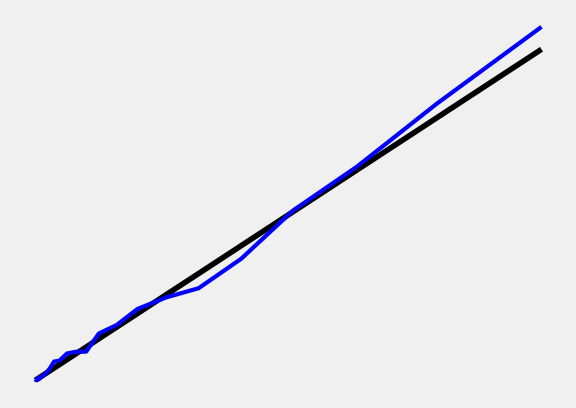

In [20]:
# Plot outputs
plt.plot(list_t, lstMSDT, color="black")
plt.plot(list_t, lstpre_MSDT, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

---------------------------------